* Author: HZQ
* Last modified: 2018/2/14


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
data	  driver   model      requirements.txt	timeline
download  LICENSE  ReadMe.md  submit		utils


In [0]:
!ls

adc.json  driver  sample_data


# Main Parts

## Import required packages

In [0]:
# !pip install --upgrade pandas
# !pip install tushare
# !pip install statsmodels

import pprint, sys, copy, datetime, functools, pickle, random, pickle, gc, math


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt 
import seaborn as sns
    
from sklearn.preprocessing import Imputer
# import tushare as ts  # for convenient fetch of stock data
# from statsmodels.tsa.stattools import adfuller  
# from statsmodels.tsa.arima_model import ARIMA  
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

%matplotlib inline

## prepared process


### load data offline

In [0]:
def reduce_mem_usage(df, verbose=True):    
    '''
    INPUT:
    df - a pandas dataframe containing raw data
    verbose - a Booler to determine print the result of storage decrease or not
    
    OUTPUT:
    
    This function will suppress INPUT.df by changing data type for storage
    '''    
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: print("Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
DATA_ROOT_PATH = "./data/"

In [0]:
data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"
data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)
data_valid = None
data_info = pd.read_excel(data_info_path, sheetname=[0, 1, 2, 3], header=None)
data_merchants = pd.read_csv(data_merchants_path)
data_new_merchant_transactions = pd.read_csv(data_new_trans_path)

/usr/local/lib/python3.6/dist-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [0]:
data_historical_transactions_reader = pd.read_csv(data_his_trans_path, chunksize=6000000)
data_historical_transactions_list = []
indent = 1

for each_chunk in data_historical_transactions_reader:
    print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
    each_chunk = reduce_mem_usage(each_chunk)
    data_historical_transactions_list.append(each_chunk)
    indent += 1
    gc.collect()
sys._clear_type_cache()
data_historical_transactions = pd.concat(data_historical_transactions_list, ignore_index=True)

del data_historical_transactions_list
del each_chunk

[Output] expected to be end in 5 runs, this is 1 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 2 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 3 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 4 run...
Mem. usage decreased to 360.49 Mb (43.7% reduction)
[Output] expected to be end in 5 runs, this is 5 run...
Mem. usage decreased to 307.16 Mb (43.7% reduction)


In [0]:
del data_historical_transactions_reader

### load data online

## middle process

### check data properties

#### check statistical characters

In [0]:
def check_basically(data_path, data):
    '''
    INPUT:
    data_path -  a string showing the store path of INPUT.data 
    data -  a pandas dataframe containing raw data
    
    OUTPUT:
    
    This function will check the statistical characters of INPUT.data
    '''
    type_dict = {}
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]
    
    print("[Input] File Name: {}, basic checking for VARIABLE \"{}\""
          .format(name_file, name_var))
    
    print("[Output] The useful statisitical characters of whole data: ")
    pprint.pprint(data.describe())
    print("\n")
    
    print("[Output] The fifth rows of raw data: ")
    pprint.pprint(data.head())
    print("\n")
    
    print("[Output] The shape of file data: ")
    pprint.pprint(data.shape)
    print("\n")
    
    print("---End Line---")
    print("\n")

In [0]:
check_basically(data_train_path, data_train)
check_basically(data_test_path, data_test)

[Input] File Name: train.csv, basic checking for VARIABLE "data_train"
[Output] The useful statisitical characters of whole data: 
           feature_1      feature_2      feature_3         target
count  201917.000000  201917.000000  201917.000000  201917.000000
mean        3.105311       1.745410       0.565569      -0.393636
std         1.186160       0.751362       0.495683       3.850500
min         1.000000       1.000000       0.000000     -33.219281
25%         2.000000       1.000000       0.000000      -0.883110
50%         3.000000       2.000000       1.000000      -0.023437
75%         4.000000       2.000000       1.000000       0.765453
max         5.000000       3.000000       1.000000      17.965068


[Output] The fifth rows of raw data: 
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            

In [0]:
check_basically(data_his_trans_path, data_historical_transactions)
check_basically(data_new_trans_path, data_new_merchant_transactions)

[Input] File Name: historical_transactions.csv, basic checking for VARIABLE "data_historical_transactions"
[Output] The useful statisitical characters of whole data: 
            city_id  installments  merchant_category_id     month_lag  \
count  2.911236e+07  2.911236e+07          2.911236e+07  2.911236e+07   
mean   1.293256e+02  6.484954e-01          4.810130e+02 -4.487294e+00   
std    1.042563e+02  2.795577e+00          2.493757e+02  3.588800e+00   
min   -1.000000e+00 -1.000000e+00         -1.000000e+00 -1.300000e+01   
25%    5.300000e+01  0.000000e+00          3.070000e+02 -7.000000e+00   
50%    9.000000e+01  0.000000e+00          4.540000e+02 -4.000000e+00   
75%    2.120000e+02  1.000000e+00          7.050000e+02 -2.000000e+00   
max    3.470000e+02  9.990000e+02          8.910000e+02  0.000000e+00   

       purchase_amount  category_2      state_id  subsector_id  
count     2.911236e+07  26459497.0  2.911236e+07  2.911236e+07  
mean      6.134567e-02         NaN  1.056679e

In [0]:
check_basically(data_merchants_path, data_merchants)

[Input] File Name: merchants.csv, basic checking for VARIABLE "data_merchants"
[Output] The useful statisitical characters of whole data: 
       merchant_group_id  merchant_category_id   subsector_id    numerical_1  \
count      334696.000000         334696.000000  334696.000000  334696.000000   
mean        31028.736143            423.131663      25.116404       0.011476   
std         31623.043426            252.898046       9.807371       1.098154   
min             1.000000             -1.000000      -1.000000      -0.057471   
25%          3612.000000            222.000000      19.000000      -0.057471   
50%         19900.000000            373.000000      27.000000      -0.057471   
75%         51707.250000            683.000000      33.000000      -0.047556   
max        112586.000000            891.000000      41.000000     183.735111   

         numerical_2  avg_sales_lag3  avg_purchases_lag3  active_months_lag3  \
count  334696.000000   334683.000000        3.346960e+05    

#### check repeatability

In [0]:
def chech_repeatability(df, col_groupby):
    '''
    INPUT:
    df - a pandas dataframe containing raw data
    col_groupby -  a string as the indicator of reindexing
    
    OUTPUT:
    is_repeatablity - a Booler value indicating the repeatablity of INPUT.df
    
    This function will check the repeatablity of INPUT.df
    '''
    print(df.shape, df.groupby(col_groupby).mean().shape)
    is_repeatability = not(df.shape[0] == df.groupby(col_groupby).mean().shape[0])
    
    return is_repeatability

In [0]:
print("[Output]The repeatability checking for training data is {}".format(chech_repeatability(data_train, "card_id")))
print("[Output]The repeatability checking for merchant data is {}".format(chech_repeatability(data_merchants, "merchant_id")))

(334696, 22) (334633, 17)
[Output]The repeatablity checking for merchant data is True


In [0]:
print("[Output]The repeatability checking for historical merchant transactions data is {}".format(chech_repeatability(data_historical_transactions, "card_id")))
print("[Output]The repeatability checking for new merchant transactions data is {}".format(chech_repeatability(data_new_merchant_transactions, "card_id")))

(29112361, 14) (325540, 8)
[Output]The repeatablity checking for historical merchant transactions data is True
(1963031, 14) (290001, 8)
[Output]The repeatablity checking for new merchant transactions data is True


#### check completion

In [0]:
def check_completion(data_path, df):
    '''
    INPUT:
    data_path -  a string showing the store path of INPUT.data 
    df -  a pandas dataframe containing raw data
    
    OUTPUT:
    
    This function will check the completion of INPUT.data
    '''    
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]

    print("[Input] File Name: {}, completion checking for VARIABLE \"{}\""
          .format(name_file, name_var)) 
    collector_df = pd.DataFrame(
        df.isnull().sum().values, columns=["feature"], 
        index=np.arange(len(df.columns))).set_index(df.columns).sort_values(by=['feature'], 
        ascending=False)
    # print("[Output] The vacancy numbers of whole data: ")
    # pprint.pprint(collector_df)
    
    print("[Output] The vacancy proportion of whole data: ")
    pprint.pprint(collector_df/df.shape[0]*100)    
    print("\n")
    
    print("---End Line---")
    print("\n")

In [0]:
check_completion(data_train_path, data_train)
check_completion(data_test_path, data_test)
check_completion(data_merchants_path, data_merchants)
check_completion(data_his_trans_path, data_historical_transactions)
check_completion(data_new_trans_path, data_new_merchant_transactions)

#### survivor bias

In [0]:
def check_target_distribution(data_path, df, col):
    '''
    INPUT:
    data_path -  a string showing the store path of INPUT.data 
    df -  a pandas dataframe containing raw data
    col -  a string indicating the column name of modeling target
    
    OUTPUT:
    
    This function will check the INPUT.col distribution of INPUT.data
    '''       
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]    
    
    print("[Input] File Name: {}, survivor bias checking for VARIABLE \"{}\"".format(name_file, name_var))
    
    print("[Output] The distribution of %s column feat: " %(col))
    count = df[col].value_counts()
    print(count)
    plt.plot(list(count.index), count.values, "o");
    plt.xlabel("The value of  column feat named %s" %col)
    plt.ylabel("Count number")
    plt.show()
    print("\n")
    
    print("---End Line---")
    print("\n")

[Input] File Name: train.csv, survivor bias checking for VARIABLE "data_train"
[Output] The distribution of target labels: 
1       196713
2          281
3           53
4           17
5           11
6            7
7            6
8            5
11           3
10           3
117          1
1630         1
13           1
14           1
17           1
19           1
28           1
2207         1
35           1
81           1
12           1
Name: target, dtype: int64


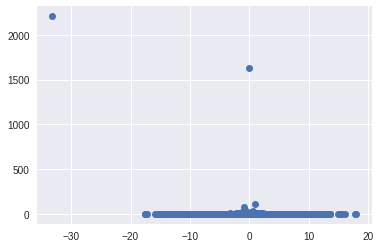



---End Line---




In [0]:
check_target_distribution(data_train_path, data_train, "target")
# check_target_distribution(data_test_path, data_test, "")

#### check time-related

|SectionName|Reference|Package|
|:--:|:--:|:--:|
|*check time-related*|[Blog1](https://jianshu.com/p/4130bac8ebe)|Pandas, Statsmodels|
|*check time-related*|[Blog2](https://jianshu.com/p/9066b9e0c7af)|Pandas, Statsmodels|



In [0]:
data_train.rolling?

In [0]:
data_train_copy = copy.copy(data_train)
data_train_dates = list(set(data_train_copy["first_active_month"]))
data_train_copy_slicedBydate = pd.DataFrame(data=[data_train_copy[data_train_copy["first_active_month"] == each_date].iloc[0, :] for each_date in data_train_dates], columns=data_train_copy.columns)
data_train_copy_slicedBydate.set_index(pd.to_datetime(data_train_copy_slicedBydate["first_active_month"]), inplace=True)
data_train_copy_slicedBydate = data_train_copy_slicedBydate.sort_index()

In [0]:
fig2 = plt.figure(figsize=(10, 12));
ax1 = fig2.add_subplot(311) 
plt.plot_date(x=data_train_copy_slicedBydate.index, y=data_train_copy_slicedBydate["target"], xdate=True, marker=None, linestyle="solid", color="darkblue", label="target");
plt.legend(loc="upper left");
ax2 = fig2.add_subplot(312) 
data_train_copy_slicedBydate["target"].rolling(6).mean().plot(color="darkgreen", label="target_rolling_mean");
plt.legend(loc="upper left");
ax3 = fig2.add_subplot(313) 
data_train_copy_slicedBydate["target"].rolling(6).std().plot(color="yellow", label="target_rolling_std");
plt.legend(loc="upper left");
# data_train_copy_slicedBydate_resampled = data_train_copy_slicedBydate.resample("W-MON")  # 数据太多时的降频处理, TODO 2018/12/17: ModuleNotFoundError: No module named "pandas.core.groupby.groupby"; "pandas.core.groupby" is not a package
# data_train_copy_slicedBydate_resampled.plot(color="darkred")

In [0]:
LABELS = ["adf statistics", "p value", "used lag", "Number of oberservation"]


# @functools.lru_cache(maxsize=128)
def check_adfuller(data):
    results = adfuller(x=data, maxlag=12)
    
    for label, result in zip(LABELS, results):
        print(label + ": " + str(result))
        
    if results[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, accept the null hypothesis")
        print("Data has unit root and is non-stationary")    

In [0]:
check_adfuller(data_train_copy_slicedBydate["target"])

In [0]:
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
print("[Input] Data: {}, visualization for VARIABLE \"{}\"".format("first derivative of \"target\"", "data_train_copy_slicedBydate[\"diff1\"]"))
data_train_copy_slicedBydate["diff1"] = data_train_copy_slicedBydate["target"].diff(1)  # Note 2018/12/13: if needed, use ".dropna()""
# pprint.pprint(data_train_copy_slicedBydate["diff1"])
print("[Output] vacancy numbers")
pprint.pprint("[Output] vacancy numbers: {}".format(data_train_copy_slicedBydate["diff1"].isnull().sum()))
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate["diff1"].plot(color="darkred", label="target_diff1", ax=ax1)
plt.legend(loc="upper left")
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate["diff1"])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
print("[Input] Data Part: {}, visualization for VARIABLE \"{}\"".format("second derivative of \"target\"", "data_train_copy_slicedBydate[\"diff2\"]"))
data_train_copy_slicedBydate["diff2"] = data_train_copy_slicedBydate["diff1"].diff(1)
# pprint.pprint(data_train_copy_slicedBydate["diff2"])
pprint.pprint("[Output] vacancy numbers: {}".format(data_train_copy_slicedBydate["diff2"].isnull().sum()))
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate["diff2"].plot(color="darkblue", label="target_diff2", ax=ax2)
plt.legend(loc="upper left")
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate["diff2"])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

In [0]:
print("[Input] Variable: {}, determine parameters \"p, q\" for financial sequence model fetched from it".format("ddata_train_copy_slicedBydate[\"diff1\"]"))
print("[Output] visualization of acf curve")
acf = plot_acf(data_train_copy_slicedBydate["target"], lags=20)
plt.show()
print("\n")
print("[Output] visualization of pacf curve")
pacf = plot_pacf(data_train_copy_slicedBydate["target"], lags=20)
plt.show()
model_arima = ARIMA(data_train_copy_slicedBydate["target"], order=(1, 1, 1), freq="W-MON")   # TODO 2018/12/19: check the right descriptions of choosing p and q from acf and pacf plotting 
result_arima = model_arima.fit()
print("\n")
print("---End Line---")
print("\n")

print("[Input] Variable: {}, visualization of fitting results for financial sequence model \"ARIMA\"".format("result_arima"))
print("[Output] visualization of summary")
print(result_arima.summary())
print("\n")
print("[Output] visualization of residual trend and distribution")
result_arima.resid.dropna(axis=0, inplace=True)
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
ax1.set_title("residual in normal format")
result_arima.resid.plot(ax=ax1)
plt.show()
fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
ax2.set_title("residual in kde format")
result_arima.resid.plot(ax=ax2, kind="kde")
plt.show()
print("\n")
print("---End Line---")
print("\n")

In [0]:
result_arima

In [0]:
data_train_copy_slicedBydate

In [0]:
print("[Input] Variable: {}, visualization of prediction results for financial sequence model \"ARIMA\"".format("result_arima"))
data_train_copy_slicedBydate["target_pred"] = result_arima.predict(start="2011-12-01", end="2018-02-01", typ="levels")
print("[Output] visualization of prediction curve compared with original curve")
data_train_copy_slicedBydate[["target", "target_pred"]].plot()
plt.show()
# pd.data_range(start="2018-12-1", end="2019-12-1", periods=12, freq="MS")
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: result_arima, visualization of prediction results for financial sequence model 'ARIMA'


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: ignored

### divide data by category

In [0]:
# TypeError: "DataFrame" objects are mutable, thus they cannot be hashed
# @functools.lru_cache(maxsize=128)


def collect_datatype(df):
    '''
    INPUT:
    df -  a pandas dataframe cotaining raw data
    
    OUTPUT:
    data_type_dict -  a dictionary containg all column data types of INPUT.data
    
    This function will find out every data type of all column data 
            (assumption: all data in one column share same data type)
    '''
    data_type_dict = {
        each_column: str(df[each_column].dtypes) for each_column in df.columns}
    
    return data_type_dict

In [0]:
# TypeError: "DataFrame" objects are mutable, thus they cannot be hashed
# @functools.lru_cache(maxsize=128)  


def collect_datadescription(df, flag_df):
    '''
    INPUT:
    df -  a pandas dataframe containing raw data
    flag_df -  a string indicating the meaning of INPUT.df
    
    OUTPUT:
    data_types_df -  a pandas dataframe containing column data type and description of INPUT.df
    
    This function will obtain column data type and description of INPUT.df
    '''
    data_types_dict = collect_datatype(df)
    data_types_dict_new = {
        each_col: [data_types_dict[each_col]] for each_col in data_types_dict}
    
    if "train" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[0][data_info[0][0] == each_col][1].values[0])
    if "his" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[1][data_info[1][0] == each_col][1].values[0])
    if "new" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[2][data_info[2][0] == each_col][1].values[0])
    if "merchant" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(
                data_info[3][data_info[3][0] == each_col][1].values[0])
   
    data_types_df = pd.DataFrame(data_types_dict_new, index=[0, 1])
    
    return data_types_df

#### check the whole data

In [0]:
data_types_dict = {"historical_transactions_datatype": collect_datatype(data_historical_transactions), "new_merchant_transactions_datatype": collect_datatype(data_new_merchant_transactions), "merchants_datatype": collect_datatype(data_merchants), "train_datatype": collect_datatype(data_train), "test_datatype": collect_datatype(data_test)}

In [0]:
columns_num, columns_nonnum = {}, {}  # Note 2019/1/31: "columns_nonnum" do not include "columns_nonnum_cate", "columns_nonnum_outlier"
columns_nonnum_cate, columns_nonnum_outlier = {}, {}

for each_csv in data_types_dict:
    columns_num[each_csv] = []
    columns_nonnum[each_csv] = []
    columns_nonnum_cate[each_csv] = []
    columns_nonnum_outlier[each_csv] = []
    
    print("[Output] The non-numbericial columns of {} is: ".format(each_csv))
    
    # pprint.pprint({each_column: [str(type(data_types_dict[each_csv][each_column][0])) if "object" in data_types_dict[each_csv][each_column] else pass] for each_column in list(data_types_dict[each_csv].keys())})
    
    for each_column in data_types_dict[each_csv]:
        if "object" in data_types_dict[each_csv][each_column] or "datetime" in data_types_dict[each_csv][each_column]:
            pprint.pprint("{} is stored as type {}".format(each_column, str(data_types_dict[each_csv][each_column])))
            # columns_nonnum[each_csv].append(each_column)
            if "his" in each_csv:
                temp = set(data_historical_transactions[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
            elif "new" in each_csv:
                temp = set(data_new_merchant_transactions[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
            elif "merchants" in each_csv:
                temp = set(data_merchants[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)                
            elif "train" in each_csv:
                temp = set(data_train[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
            elif "test" in each_csv:
                temp = set(data_test[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
        else:
            columns_num[each_csv].append(each_column) 
    print("The ratio of non-numbericial columns is {}".format(len(columns_nonnum[each_csv])/len(data_types_dict[each_csv].keys())))
    print("\n")
    gc.collect()
    sys._clear_type_cache()

[Output] The non-numbericial columns of historical_transactions_datatype is: 
'authorized_flag is stored as type object'
'card_id is stored as type object'
'category_1 is stored as type object'
'category_3 is stored as type object'
'merchant_id is stored as type object'
'purchase_date is stored as type object'
The ratio of non-numbericial columns is 0.2857142857142857


[Output] The non-numbericial columns of new_merchant_transactions_datatype is: 
'authorized_flag is stored as type object'
'card_id is stored as type object'
'category_1 is stored as type object'
'category_3 is stored as type object'
'merchant_id is stored as type object'
'purchase_date is stored as type object'
The ratio of non-numbericial columns is 0.2857142857142857


[Output] The non-numbericial columns of merchants_datatype is: 
'merchant_id is stored as type object'
'category_1 is stored as type object'
'most_recent_sales_range is stored as type object'
'most_recent_purchases_range is stored as type object'
'cate

#### check individual data

In [0]:
data_train_des = collect_datadescription(data_train, "train")
data_train_des

,card_id,feature_1,feature_2,feature_3,first_active_month,target
0,object,int64,int64,int64,object,float64
1,Unique card identifier,Anonymized card categorical feature,Anonymized card categorical feature,Anonymized card categorical feature,"'YYYY-MM', month of first purchase",Loyalty numerical score calculated 2 months af...


In [0]:
data_train_des[columns_nonnum["train_datatype"]]

In [0]:
data_historical_transactions_des = collect_datadescription(data_historical_transactions, "his")
data_historical_transactions_des

,authorized_flag,card_id,category_1,category_2,category_3,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id
0,object,object,object,float16,object,int16,int16,int16,object,int8,float32,object,int8,int8
1,"Y' if approved, 'N' if denied",Card identifier,anonymized category,anonymized category,anonymized category,City identifier (anonymized ),number of installments of purchase,Merchant category identifier (anonymized ),Merchant identifier (anonymized),month lag to reference date,Normalized purchase amount,Purchase date,State identifier (anonymized ),Merchant category group identifier (anonymized )


In [0]:
data_historical_transactions_des[columns_nonnum["historical_transactions_datatype"]]

In [0]:
data_new_merchant_transactions_des = collect_datadescription(data_new_merchant_transactions, "new")
data_new_merchant_transactions_des

,authorized_flag,card_id,category_1,category_2,category_3,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id
0,object,object,object,float64,object,int64,int64,int64,object,int64,float64,object,int64,int64
1,"Y' if approved, 'N' if denied",Card identifier,anonymized category,anonymized category,anonymized category,City identifier (anonymized ),number of installments of purchase,Merchant category identifier (anonymized ),Merchant identifier (anonymized),month lag to reference date,Normalized purchase amount,Purchase date,State identifier (anonymized ),Merchant category group identifier (anonymized )


In [0]:
data_new_merchant_transactions_des[columns_nonnum["new_merchant_transactions_datatype"]]

In [0]:
data_merchants_des = collect_datadescription(data_merchants, "merchant")
data_merchants_des

,active_months_lag12,active_months_lag3,active_months_lag6,avg_purchases_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_sales_lag12,avg_sales_lag3,avg_sales_lag6,category_1,...,city_id,merchant_category_id,merchant_group_id,merchant_id,most_recent_purchases_range,most_recent_sales_range,numerical_1,numerical_2,state_id,subsector_id
0,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,...,int64,int64,int64,object,object,object,float64,float64,int64,int64
1,Quantity of active months within last 12 months,Quantity of active months within last 3 months,Quantity of active months within last 6 months,Monthly average of transactions in last 12 mon...,Monthly average of transactions in last 3 mont...,Monthly average of transactions in last 6 mont...,Monthly average of revenue in last 12 months d...,Monthly average of revenue in last 3 months di...,Monthly average of revenue in last 6 months di...,anonymized category,...,City identifier (anonymized ),Unique identifier for merchant category (anony...,Merchant group (anonymized ),Unique merchant identifier,Range of quantity of transactions in last acti...,Range of revenue (monetary units) in last acti...,anonymized measure,anonymized measure,State identifier (anonymized ),Merchant category group (anonymized )


In [0]:
data_merchants_des[columns_nonnum["merchants_datatype"]]

#### read or save division

In [0]:
# fw = open(DATA_ROOT_PATH+"/collector/data_type_num.pkl", "wb")
# pickle.dump(columns_num, fw)
# fw.close()
# fw = open(DATA_ROOT_PATH+"/collector/data_type_nonnum.pkl", "wb")
# pickle.dump(columns_nonnum, fw)
# fw.close()
# fw = open(DATA_ROOT_PATH+"/collector/data_type_categorical.pkl", "wb")
# pickle.dump(columns_nonnum_cate, fw)
# fw.close()
# fw = open(DATA_ROOT_PATH+"/collector/data_type_nonnum_outlier.pkl", "wb")
# pickle.dump(columns_nonnum_outlier, fw)
# fw.close()

fr = open(DATA_ROOT_PATH+"/collector/data_type_num.pkl", "rb")
columns_num = pickle.load(fr)
fr.close()
fr = open(DATA_ROOT_PATH+"/collector/data_type_nonnum.pkl", "rb")
columns_nonnum = pickle.load(fr)
fr.close()
fr = open(DATA_ROOT_PATH+"/collector/data_type_categorical.pkl", "rb")
columns_nonnum_cate = pickle.load(fr)
fr.close()
fr = open(DATA_ROOT_PATH+"/collector/data_type_nonnum_outlier.pkl", "rb")
columns_nonnum_outlier = pickle.load(fr)
fr.close()

### expand training and testing data

In [0]:
# for df in [data_historical_transactions, data_new_merchant_transactions]:
#     df['category_2'].fillna(1.0,inplace=True)
#     df['category_3'].fillna('A',inplace=True)
# data_merchants.category_2.fillna(1.0,inplace=True)

# data_historical_transactions.fillna(data_historical_transactions.mode(), inplace=True)
# data_new_merchant_transactions.fillna(data_historical_transactions.mode(), inplace=True)
# data_merchants.fillna(data_merchants.mode(), inplace=True)

####  deal with outliers

|To-dos|Reference|
|:--:|:--:|:--:|
|anomaly detection algorithms comparison|[Sklearn docs](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)
|IsolationForest example|[Sklearn docs](https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py)



* outliers brought by modeling target distribution

*Note 2019/2/8*: 

*obtain by survivor bias checking above, easy to see the small group of edge-distributed data: label outliers*

In [0]:
data_train["Outlier"] = 0
data_train.loc[data_train["target"] < -30, "Outlier"] = 1
data_train.loc[data_train["target"] == 0, "Outlier"] = 1

# data_train.drop((data_train["target"] < -30).index,axis=0, inplace=True)

* outliers brought by column data distribution

*Note 2019/2/8*: 

*obtain by statisical checking above (like abnormal std, mean or max value): replaced by Nan*

*obtained by data type division: drop outliers*

**new merchant transactions**

In [0]:
columns_nonnum_outlier

{'historical_transactions_datatype': [],
 'merchants_datatype': [],
 'new_merchant_transactions_datatype': ['authorized_flag'],
 'test_datatype': [],
 'train_datatype': []}

In [0]:
data_new_merchant_transactions.drop(["authorized_flag"], axis=1, inplace=True)

In [0]:
from sklearn.neighbors import LocalOutlierFactor


cols = ["purchase_amount"]
pred, data_score = {each_col:0 for each_col in cols}, {each_col:0 for each_col in cols}
data = data_new_merchant_transactions[cols].dropna()

clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
for each_col in cols:    
    pred[each_col] = clf_lof.fit_predict(data[each_col].values.reshape(-1, 1))
    data_score[each_col] = clf_lof.negative_outlier_factor_
    gc.collect()
sys._clear_type_cache()

for each_col, each_pred in pred.items():
    data_new_merchant_transactions.loc[:, each_col+"_binary"] = 0
    data_new_merchant_transactions.loc[data[each_pred==-1].index, each_col+"_binary"] = 1
    # data_new_merchant_transactions.loc[data[each_pred==-1].index, each_col] = np.nan  

In [0]:
# data_new_merchant_transactions["city_id"][data_new_merchant_transactions["city_id"] == -1] = np.nan
data_new_merchant_transactions["merchant_category_id"][data_new_merchant_transactions["merchant_category_id"] == -1] = np.nan

**historical transaction**

*Note 2019/2/8*: 

*obtain by statisical checking above (like abnormal std, mean or max value): cut off and generate indicator feat, replaced by Nan*

In [0]:
index = np.arange(1, 1000, 2)
collector_count = [data_historical_transactions["purchase_amount"][data_historical_transactions["purchase_amount"] > each_num].shape[0] for each_num in index]
collector_mean= [(data_historical_transactions["purchase_amount"][data_historical_transactions["purchase_amount"] <= each_num]).mean() for each_num in index]
collector_std = [(data_historical_transactions["purchase_amount"][data_historical_transactions["purchase_amount"] <= each_num]).std() for each_num in index]
collector_boundary = [3.291 * collector_std[int((each_num-1)/2)]/np.sqrt(data_historical_transactions["purchase_amount"][data_historical_transactions["purchase_amount"] <= each_num].shape[0]) for each_num in index]

In [0]:
index = np.arange(1, 1000, 2)
data_historical_transactions["purchase_amount_binary"] = 0
index_outlier = data_historical_transactions["purchase_amount"][data_historical_transactions["purchase_amount"] > index[92]].index
data_historical_transactions.loc[index_outlier, "purchase_amount_binary"] = 1
data_historical_transactions.loc[index_outlier, "purchase_amount"] = np.nan

In [0]:
# data_historical_transactions["city_id"][data_historical_transactions["city_id"] == -1] = np.nan
data_historical_transactions["merchant_category_id"][data_historical_transactions["merchant_category_id"] == -1] = np.nan

**merchants**

*Note 2019/2/9*: 

*obtain by statisical checking above (like abnormal std, mean or max value): drop, generate indicator feat and replaced by Nan*

In [0]:
data_merchants.drop(["merchant_category_id", "city_id", "merchant_group_id"], axis=1, inplace=True)

In [0]:
from sklearn.neighbors import LocalOutlierFactor


cols = ["avg_sales_lag3", "avg_purchases_lag3", "avg_sales_lag6",
        "avg_purchases_lag6", "avg_sales_lag12", "avg_purchases_lag12"]
pred, data_score = {each_col:0 for each_col in cols}, {each_col:0 for each_col in cols}
data = data_merchants[cols].dropna()

clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
for each_col in cols:    
    pred[each_col] = clf_lof.fit_predict(data[each_col].reshape(-1, 1))
    data_score[each_col] = clf_lof.negative_outlier_factor_
    gc.collect()
sys._clear_type_cache()

In [0]:
for each_col, each_pred in pred.items():
    data_merchants.loc[:, each_col+"_binary"] = 0
    data_merchants.loc[data[each_pred==-1].index, each_col+"_binary"] = 1
    data_merchants.loc[data[each_pred==-1].index, each_col] = np.nan     

* outliers brought by vacancy

*Note 2019/2/8*: 

*obtain by completion checking above: drop outliers*

In [0]:
data_historical_transactions.drop(index=data_historical_transactions[data_historical_transactions.merchant_id.isnull()].index, axis=0, inplace=True)
data_new_merchant_transactions.drop(index=data_new_merchant_transactions[data_new_merchant_transactions.merchant_id.isnull()].index, axis=0, inplace=True)

####  UDF features

##### de-normalize raw data

In [0]:
# mean, std = data_new_merchant_transactions["purchase_amount"].mean(), data_new_merchant_transactions["purchase_amount"].std()
# data_new_merchant_transactions["purchase_amount_decentral"] = data_new_merchant_transactions["purchase_amount"] / std
data_new_merchant_transactions["purchase_amount_new"] = np.round(data_new_merchant_transactions["purchase_amount"] / 0.00150265118 + 497.06, 2)

# mean2, std2 = data_historical_transactions["purchase_amount"].mean(), data_historical_transactions["purchase_amount"].std()
# data_historical_transactions["purchase_amount_decentral"] = data_historical_transactions["purchase_amount"] / std
data_historical_transactions["purchase_amount_new"] = np.round(data_historical_transactions["purchase_amount"] / 0.00150265118 + 497.06, 2)

##### deal with categorical data (binary)

In [0]:
def apply_binarize(df, flag_df):
    '''
    INPUT:
    df -  a pandas dataframe containing raw data
    flag_df -  a string indicating the meaning of INPUT.df
    
    OUTPUT:
    df -  a pandas dataframe containing categorical data after binarized
    
    This function will binarize categorical data of INPUT.df
    '''
    if "his" in flag_df:
        for column in columns_nonnum_cate["historical_transactions_datatype"]:
            df[column] = df[column].map({"Y":1, "N":0})
    elif "merchant" in flag_df:
        for column in columns_nonnum_cate["merchants_datatype"]:
            df[column] = df[column].map({"Y":1, "N":0})
    elif "new" in flag_df:
        for column in columns_nonnum_cate["new_merchant_transactions_datatype"]:
            df[column] = df[column].map({"Y":1, "N":0})
    
    return df

In [0]:
# TODO 2019/2/10: new docstring formation
#     OUTPUT:
#     df -  a new pandas dataframe that has the following characteristics:
#             1. contains all columns that were not specified as categorical
#             2. removes all the original columns in cat_cols
#             3. dummy columns for each of the categorical columns in cat_cols
#             4. if dummy_na is True - it also contains dummy columns for the NaN values
#             5. Use a prefix of the column name with an underscore (_) for separating


def create_dummy(df, col_categ, dummy_na=False):
    '''
    INPUT:
    df -  a pandas dataframe with categorical variables you want to dummy
    col_categ -  a list containing strings that are associated with names of 
                          the categorical columns
    dummy_na -  a Bool holding whether you want to dummy NA vals of 
                             categorical columns or not
    
    OUTPUT:
    df -  a new pandas dataframe after transforming specific categorical column feat in 
            INPUT.col_categ to numbercial column feat
    
    This function will create dummy data and dummy columns from INPUT.df
    '''
    for col in  col_categ:
        try:
            df = pd.concat(
                [df.drop(col, axis=1), 
                        pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=dummy_na)], 
                axis=1)
        except:
            continue
            
    return df

In [0]:
columns_nonnum_cate

{'historical_transactions_datatype': ['authorized_flag', 'category_1'],
 'merchants_datatype': ['category_1', 'category_4'],
 'new_merchant_transactions_datatype': ['category_1'],
 'test_datatype': [],
 'train_datatype': []}

In [0]:
data_new_merchant_transactions = apply_binarize(data_new_merchant_transactions, "new")
data_historical_transactions = apply_binarize(data_historical_transactions, "his")
data_merchants = apply_binarize(data_merchants, "merchant")

save or read data

In [0]:
# data_historical_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_noOutlier_noBinary_20190209.csv", index=False)
# data_new_merchant_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_noOutlier_noBinary_20190209.csv", index=False)
# data_merchants.to_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_noOutlier_noBinary_20190209.csv", index=False)

data_historical_transactions_reader = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_noOutlier_noBinary_20190209.csv", chunksize=6000000)
data_new_merchant_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_noOutlier_noBinary_20190209.csv")
data_merchants = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_noOutlier_noBinary_20190209.csv")

In [0]:
data_historical_transactions_list = []
indent = 1

for each_chunk in data_historical_transactions_reader:
    print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
    each_chunk = reduce_mem_usage(each_chunk)
    data_historical_transactions_list.append(each_chunk)
    indent += 1
    gc.collect()
sys._clear_type_cache()
data_historical_transactions = pd.concat(data_historical_transactions_list, ignore_index=True)

del data_historical_transactions_list
del each_chunk
del data_historical_transactions_reader

[Output] expected to be end in 5 runs, this is 1 run...
Mem. usage decreased to 297.55 Mb (59.4% reduction)
[Output] expected to be end in 5 runs, this is 2 run...
Mem. usage decreased to 297.55 Mb (59.4% reduction)
[Output] expected to be end in 5 runs, this is 3 run...
Mem. usage decreased to 297.55 Mb (59.4% reduction)
[Output] expected to be end in 5 runs, this is 4 run...
Mem. usage decreased to 297.55 Mb (59.4% reduction)
[Output] expected to be end in 5 runs, this is 5 run...
Mem. usage decreased to 253.53 Mb (59.4% reduction)


##### deal with mixed data

|FunctionName|Reference|
|:--:|:--:|:--:|
|apply_extraction2datedata|[My first kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)



In [0]:
month_dict = \
        {1:"January", 
         2:"February", 
         3:"March", 
         4:"April", 
         5:"May", 
         6:"June", 
         7:"July", 
         8:"August", 
         9:"September", 
         10:"October", 
         11:"November", 
         12:"December"}


def hour_to_string(each_time):
    if each_time > 4 and each_time < 12:
        return "Morning"
    elif each_time >= 12 and each_time < 17:
        return "Afternoon"
    elif each_time >= 17 and each_time < 21:
        return "Evening"
    else:
        return "Night"

In [0]:
def apply_extraction2datedata(df, flag_df):
    '''
    INPUT:
    df -  a pandas dataframe containing raw data
    flag_df -  a string indicating the meaning of INPUT.df
    
    OUTPUT:
    df -  a pandas dataframe containing expanded data after extraction
    
    This function will extract numberical data from date data of INPUT.df
    '''  
    if "his" in flag_df or "new" in flag_df:
        df["purchase_date"] = pd.to_datetime(df["purchase_date"])
        # df["purchase_year"] = df["purchase_date"].dt.year
        df["purchase_weekofyear"] = df["purchase_date"].dt.weekofyear
        df["purchase_month"] = df["purchase_date"].dt.month
        df["purchase_month_session"] = df["purchase_month"].map(month_dict)
        df["purchase_dayofweek"] = df["purchase_date"].dt.dayofweek
        df["purchase_weekend"] = (df.purchase_date.dt.weekday >= 5).astype(int)
        df["purchase_hour"] = df["purchase_date"].dt.hour
        df["purchase_diarysession"] = \
            df["purchase_hour"].apply(lambda x: hour_to_string(x))
        df['month_diff'] = \
            ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
        df['month_diff'] += df['month_lag']
        df.drop(["purchase_date"], axis=1, inplace=True)  
    elif "train" in flag_df or "test" in flag_df:
        df["first_active_month"] = pd.to_datetime(df["first_active_month"])
        df["first_active_month_dayofweek"] = df["first_active_month"].dt.dayofweek
        df["first_active_month_weekofyear"] = df["first_active_month"].dt.weekofyear
        df["first_active_month_month"] = df["first_active_month"].dt.month
        # df["first_active_month_monthsession"] = \
        #        df["first_active_month_month"].map(month_dict)
        df["first_active_month_elapsed_time_today"] = (datetime.datetime.today()
                                                          - df["first_active_month"]).dt.days
        df["first_active_month_elapsed_time_specific"] = (datetime.date(2018, 2, 1) 
                                                          - df['first_active_month'].dt.date).dt.days
        df["first_active_month_hour"] = df["first_active_month"].dt.hour
        # df["first_active_month_diarysession"] = df["first_active_month_hour"].apply(lambda x: hour_to_string(x))
        df.drop(["first_active_month"], axis=1, inplace=True)
    
    gc.collect()
    sys._clear_type_cache()
    
    return df

In [0]:
data_historical_transactions = apply_extraction2datedata(data_historical_transactions, "his")
print("[Output] Finish one task......")
data_new_merchant_transactions = apply_extraction2datedata(data_new_merchant_transactions, "new")
print("[Output] Finish two tasks......")

data_train = apply_extraction2datedata(data_train, "train")
print("[Output] Finish three tasks......")
data_test = apply_extraction2datedata(data_test, "test")
print("[Output] All done!")

[Output] Finish one task......
[Output] Finish two tasks......
[Output] Finish three tasks......
[Output] All done!


In [0]:
data_historical_transactions = reduce_mem_usage(data_historical_transactions)
data_merchants = reduce_mem_usage(data_merchants)
data_new_merchant_transactions = reduce_mem_usage(data_new_merchant_transactions)

Mem. usage decreased to 2054.51 Mb (36.2% reduction)
Mem. usage decreased to 25.85 Mb (54.0% reduction)
Mem. usage decreased to 136.66 Mb (60.3% reduction)


read and  save data

In [0]:
# data_historical_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_noOutlier_noMixed_20190214.csv", index=False)
# data_new_merchant_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_noOutlier_noMixed_20190214.csv", index=False)
# data_train.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_noOutlier_noMixed_20190214.csv", index=False)
# data_test.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_noOutlier_noMixed_20190214.csv", index=False)

data_historical_transactions_reader = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_noOutlier_noMixed_20190214.csv", chunksize=6000000)
data_new_merchant_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_noOutlier_noMixed_20190214.csv")
data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_noOutlier_noMixed_20190214.csv")
data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_noOutlier_noMixed_20190214.csv")

In [0]:
data_historical_transactions_list = []
indent = 1

for each_chunk in data_historical_transactions_reader:
    print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
    each_chunk = reduce_mem_usage(each_chunk)
    data_historical_transactions_list.append(each_chunk)
    indent += 1
    gc.collect()
sys._clear_type_cache()
data_historical_transactions = pd.concat(data_historical_transactions_list, ignore_index=True)

del data_historical_transactions_list
del each_chunk

[Output] expected to be end in 5 runs, this is 1 run...
Mem. usage decreased to 360.49 Mb (62.5% reduction)
[Output] expected to be end in 5 runs, this is 2 run...
Mem. usage decreased to 360.49 Mb (62.5% reduction)
[Output] expected to be end in 5 runs, this is 3 run...
Mem. usage decreased to 360.49 Mb (62.5% reduction)
[Output] expected to be end in 5 runs, this is 4 run...
Mem. usage decreased to 360.49 Mb (62.5% reduction)
[Output] expected to be end in 5 runs, this is 5 run...
Mem. usage decreased to 298.84 Mb (62.5% reduction)


In [0]:
del data_historical_transactions_reader

#####  combine all in one table

|FunctionName|Reference|
|:--:|:--:|
|Aggregate transactions|[Elo world](https://www.kaggle.com/fabiendaniel/elo-world)



###### apply numberical transformation

In [0]:
columns_nonnum_cate

{'historical_transactions_datatype': ['authorized_flag', 'category_1'],
 'merchants_datatype': ['category_1', 'category_4'],
 'new_merchant_transactions_datatype': ['category_1'],
 'test_datatype': [],
 'train_datatype': []}

In [0]:
# data_train = pd.get_dummies(data_train, columns=["first_active_month_monthsession"])
# data_test = pd.get_dummies(data_test, columns=["first_active_month_monthsession"])

data_historical_transactions = pd.get_dummies(data_historical_transactions, columns=["category_2", "category_3", "purchase_month_session", "purchase_diarysession"], drop_first=False)
data_new_merchant_transactions = pd.get_dummies(data_new_merchant_transactions, columns=["category_2", "category_3", "purchase_month_session", "purchase_diarysession"], drop_first=False)
data_merchants = pd.get_dummies(data_merchants, columns=["most_recent_sales_range", "most_recent_purchases_range"])

In [0]:
data_historical_transactions = reduce_mem_usage(data_historical_transactions)
data_merchants = reduce_mem_usage(data_merchants)
data_new_merchant_transactions = reduce_mem_usage(data_new_merchant_transactions)

Mem. usage decreased to 1998.99 Mb (0.0% reduction)
Mem. usage decreased to 23.94 Mb (0.0% reduction)
Mem. usage decreased to 132.92 Mb (0.0% reduction)


In [0]:
for each_col in data_train.columns:
    if "first_active_month_monthsession" in each_col:
        columns_nonnum_cate["train_datatype"].append(each_col)
        columns_nonnum_cate["test_datatype"].append(each_col)
        
for each_col in data_new_merchant_transactions.columns:
    if "category_3_" in each_col or "category_2_" in each_col or "purchase_month_" in each_col or "purchase_diarysession" in each_col:
        columns_nonnum_cate["historical_transactions_datatype"].append(each_col)
        columns_nonnum_cate["new_merchant_transactions_datatype"].append(each_col) 

for each_col in data_merchants.columns:
    if "most_recent_sales_range_" in each_col or "most_recent_purchases_range_" in each_col:
        columns_nonnum_cate["merchants_datatype"].append(each_col)        

In [0]:
columns_nonnum_cate

{'historical_transactions_datatype': ['authorized_flag',
  'category_1',
  'category_2_1.0',
  'category_2_2.0',
  'category_2_3.0',
  'category_2_4.0',
  'category_2_5.0',
  'category_3_A',
  'category_3_B',
  'category_3_C',
  'purchase_month_session_April',
  'purchase_month_session_August',
  'purchase_month_session_December',
  'purchase_month_session_February',
  'purchase_month_session_January',
  'purchase_month_session_July',
  'purchase_month_session_June',
  'purchase_month_session_March',
  'purchase_month_session_May',
  'purchase_month_session_November',
  'purchase_month_session_October',
  'purchase_month_session_September',
  'purchase_diarysession_Afternoon',
  'purchase_diarysession_Evening',
  'purchase_diarysession_Morning',
  'purchase_diarysession_Night'],
 'merchants_datatype': ['category_1',
  'category_4',
  'most_recent_sales_range_A',
  'most_recent_sales_range_B',
  'most_recent_sales_range_C',
  'most_recent_sales_range_D',
  'most_recent_sales_range_E',
 

save or read data

In [0]:
data_train.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_noOutlier_noMixed_mod1_20190213.csv", index=False)
print("[Output] Finish one task......")
data_test.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_noOutlier_noMixed_mod1_20190213.csv", index=False)
print("[Output] Finish two tasks......")
data_historical_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_noOutlier_noMixed_mod1_20190213.csv", index=False)
print("[Output] Finish three tasks......")
data_new_merchant_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_noOutlier_noMixed_mod1_20190213.csv", index=False)
print("[Output] Finish four tasks......")
data_merchants.to_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_noOutlier_noMixed_mod1_20190213.csv", index=False)
print("[Output] All done!")

# data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_noOutlier_noMixed_mod1_20190213.csv")
# data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_noOutlier_noMixed_mod1_20190213.csv")
# data_new_merchant_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_noOutlier_noMixed_mod1_20190213.csv")
# data_merchants = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_noOutlier_noMixed_mod1_20190213.csv")
# data_historical_transactions_reader = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_noOutlier_noMixed_mod1_20190213.csv", chunksize=6000000)
# data_historical_transactions_reader.get_chunk(5)

[Output] Finish one task......
[Output] Finish two tasks......
[Output] Finish three tasks......
[Output] Finish four tasks......
[Output] All done!


In [0]:
# TODO 2019/2/5: test fillling Nan if needed


temp = data_test["card_id"]
data_test.drop(["card_id"], axis=1, inplace=True)

filler_vacancy = Imputer()
data_test = pd.DataFrame(data=filler_vacancy.fit_transform(data_test), columns=data_test.columns)

data_test["card_id"] = temp
del temp

In [0]:
data_historical_transactions_list = []
indent = 1

for each_chunk in data_historical_transactions_reader:
    print("[Output] expected to be end in 5 runs, this is {} run...".format(indent))
    # each_chunk.drop(["Unnamed: 0"], axis=1, inplace=True)
    each_chunk = reduce_mem_usage(each_chunk)
    data_historical_transactions_list.append(each_chunk)
    indent += 1
    gc.collect()
sys._clear_type_cache()
data_historical_transactions = pd.concat(data_historical_transactions_list, ignore_index=True)

del data_historical_transactions_list
del data_historical_transactions_reader

[Output] expected to be end in 5 runs, this is 1 run...
Mem. usage decreased to 349.04 Mb (81.4% reduction)
[Output] expected to be end in 5 runs, this is 2 run...
Mem. usage decreased to 349.04 Mb (81.4% reduction)
[Output] expected to be end in 5 runs, this is 3 run...
Mem. usage decreased to 349.04 Mb (81.4% reduction)
[Output] expected to be end in 5 runs, this is 4 run...
Mem. usage decreased to 349.04 Mb (81.4% reduction)
[Output] expected to be end in 5 runs, this is 5 run...
Mem. usage decreased to 289.35 Mb (81.4% reduction)


###### apply aggregation

In [0]:
# TODO 2019/2/5: unsolved vacancy problem caused by using "std" as a part of aggregation fuction


def aggregate_transactions(df):
    """
    INPUT:
    df -  a pandas dataframe containing data after dealing with outliers, mixed feature
    
    OUTPUT:
    agg_df -  a pandas dataframe containing data after aggregation
    
    This function applly specific aggregation to INPUT.df
    """
    agg_func = {
    "category_1": ["sum", "mean"],
    "category_2_1.0": ["mean"],
    "category_2_2.0": ["mean"],
    "category_2_3.0": ["mean"],
    "category_2_4.0": ["mean"],
    "category_2_5.0": ["mean"],
    "category_3_A": ["mean"],
    "category_3_B": ["mean"],
    "category_3_C": ["mean"],
    # "city_id": ["nunique"],
    "installments": ["sum", "mean", "max", "min", "std"],
    "merchant_id": ["nunique"],
    "merchant_category_id": ["nunique"],
    "month_diff": ["sum", "mean", "max", "min", "std"],        
    "month_lag": ["sum", "mean", "max", "min", "std"],
    "purchase_amount": ["sum", "mean", "max", "min", "std"],
    "purchase_amount_binary": ["mean"],
    "purchase_amount_new": ["sum", "mean", "max", "min", "std"],    
    # "purchase_date": [np.ptp, "min", "max"],
    "purchase_dayofweek": ["mean", "max", "min"],
    "purchase_diarysession_Afternoon": ["mean"],
    "purchase_diarysession_Evening": ["mean"],
    "purchase_diarysession_Morning": ["mean"],
    "purchase_diarysession_Night": ["mean"],
    "purchase_hour": ["mean", "max", "min"],
    "purchase_month": ["sum", "mean", "max", "min", "std"],
    "purchase_month_session_April": ["mean"],
    "purchase_month_session_August": ["mean"],
    "purchase_month_session_December": ["mean"],
    "purchase_month_session_February": ["mean"],
    "purchase_month_session_January": ["mean"],
    "purchase_month_session_July": ["mean"],
    "purchase_month_session_June": ["mean"],
    "purchase_month_session_March": ["mean"],
    "purchase_month_session_May": ["mean"],
    "purchase_month_session_November": ["mean"],
    "purchase_month_session_October": ["mean"],
    "purchase_month_session_September": ["mean"], 
    "purchase_weekend": ["mean", "max", "min"],
    "purchase_weekofyear": ["mean", "max", "min"],
    # "state_id": ["nunique"],
    "subsector_id": ["nunique"]       
    } 
    
    agg_df = df.groupby(["card_id"]).agg(agg_func)
    agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    df = (df.groupby("card_id").size().reset_index(name="transactions_count"))
    agg_df = pd.merge(df, agg_df, on="card_id", how="left")
     
    gc.collect()
    sys._clear_type_cache()   
    
    return agg_df

In [0]:
# TODO 2019/2/5: unsolved vacancy problem caused by using "std" as a part of aggregation fuction


def aggregate_per_month(df):
    """
    INPUT:
    df -  a pandas dataframe containing data after dealing with outliers, mixed feature
    
    OUTPUT:
    agg_df -  a pandas dataframe after aggregation
    
    This function applly specific aggregation to INPUT.df
    """
    df_grouped = df.groupby(["card_id", "month_lag"])

    agg_func = {
            "purchase_amount": ["count", "sum", "mean", "min", "max", "std"],
            "installments": ["count", "sum", "mean", "min", "max", "std"],
            }

    intermediate_group = df_grouped.agg(agg_func)
    intermediate_group.columns = ["_".join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    agg_df = intermediate_group.groupby("card_id").agg(["mean", "std"])
    agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)

    gc.collect()
    sys._clear_type_cache()    
    
    return agg_df

In [0]:
def successive_aggregates(df, col1, col2):
    """
    INPUT:
    df -  a pandas dataframe containing data after dealing with outliers, mixed feature
    col1 -  a string indicating how to aggregate
    col2 -  a string indicating how to aggregate 
    
    OUTPUT:
    agg_df -  a pandas dataframe after aggregation
    
    This function applly specific aggregation to INPUT.df
    """
    t = df.groupby(["card_id", col1])[col2].mean()
    agg_df = pd.DataFrame(t).reset_index().groupby("card_id")[col2].agg(["mean", "min", "max", "std"])
    agg_df.columns = [col1 + "_" + col2 + "_" + col for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    gc.collect()
    sys._clear_type_cache()    
    
    return agg_df

In [0]:
# Note 2019/2/1: not consider "merchant_group_id": ["nunique"] for simplifying grouping
# TODO 2019/2/1: how to explain "df_agg["merchant_id_"]" can not be replaced by ".merchant_id_"?


def aggregate_merchants(df, df_merchant):
    '''
    INPUT:
    df -  a pandas dataframe containing data after dealing with outliers, mixed feature
    df_merchant -  a specific pandas dataframe containing data of several merchants
    
    OUTPUT:
    df_agg_merchant -  a pandas dataframe after aggregation from merchants csv file
    
    This function applly specific aggregation to INPUT.df
    '''
    df_agg["merchant_id_"] = df["merchant_id"]
    df_agg_merchant = pd.merge(df, df_merchant, on="merchant_id_", how="left")
    
    gc.collect()
    sys._clear_type_cache()   
    
    return df_agg_merchant

In [0]:
print("Excecute aggregation to VARIABLE data_historical_transactions")

print("[Input] Aggregate authorized_flag")
agg_fun = {"authorized_flag": ["mean"]}
auth_mean_his = data_historical_transactions.groupby(["card_id"]).agg(agg_fun)
auth_mean_his.columns = ["_".join(col).strip() for col in auth_mean_his.columns.values]
auth_mean_his.reset_index(inplace=True)
data_historical_transactions_authorized = data_historical_transactions[data_historical_transactions['authorized_flag'] == 1]
data_historical_transactions_Notauthorized = data_historical_transactions[data_historical_transactions['authorized_flag'] == 0]
gc.collect()
sys._clear_type_cache()

print("[Input] Aggregate specific columns by FUNCTION aggregate_transactions")
# data_historical_transactions_agg = aggregate_transactions(data_historical_transactions)
# data_historical_transactions_agg.columns = ['his_trans_' + each_col if each_col != 'card_id' else each_col for each_col in data_historical_transactions_agg.columns]
# data_historical_transactions_agg2 =  aggregate_per_month(data_historical_transactions) 
data_historical_transactions_Notauthorized_agg = aggregate_transactions(data_historical_transactions_Notauthorized)
data_historical_transactions_Notauthorized_agg.columns = ['his_trans_' + each_col if each_col != 'card_id' else each_col for each_col in data_historical_transactions_Notauthorized_agg.columns]
data_historical_transactions_authorized_agg = aggregate_transactions(data_historical_transactions_authorized)
data_historical_transactions_authorized_agg.columns = ['his_trans_' + each_col if each_col != 'card_id' else each_col for each_col in data_historical_transactions_authorized_agg.columns]

print("[Input] Aggregate specific columns by FUNCTION aggregate_per_month")
data_historical_transactions_authorized_agg2 =  aggregate_per_month(data_historical_transactions_authorized) 

Excecute aggregation to VARIABLE data_historical_transactions
[Input] Aggregate authorized_flag
[Input] Aggregate specific columns by FUNCTION aggregate_transactions
[Input] Aggregate specific columns by FUNCTION aggregate_per_month


In [0]:
del data_historical_transactions

In [0]:
# TODO 2019/2/5: test fillling Nan if needed


temp = data_historical_transactions_authorized_agg2["card_id"]
data_historical_transactions_authorized_agg2.drop(["card_id"], axis=1, inplace=True)

filler_vacancy = Imputer()
data_historical_transactions_authorized_agg2 = pd.DataFrame(data=filler_vacancy.fit_transform(data_historical_transactions_authorized_agg2), columns=data_historical_transactions_authorized_agg2.columns)

data_historical_transactions_authorized_agg2["card_id"] = temp
del temp

In [0]:
print("Excecute aggregation to VARIABLE data_new_merchant_transactions")

print("[Input] Aggregate specific columns by FUNCTION aggregate_transactions")
data_new_merchant_transactions_agg = aggregate_transactions(data_new_merchant_transactions)
data_new_merchant_transactions_agg.columns = ['new_trans_' + each_col if each_col != 'card_id' else each_col for each_col in data_new_merchant_transactions_agg.columns]

print("[Input] Aggregate specific columns by FUNCTION successive_aggregates")
data_new_merchant_transactions_agg2 = successive_aggregates(data_new_merchant_transactions, 'category_1', 'purchase_amount')
# print((data_new_merchant_transactions_agg2.isnull().mean() > 0.1).sum())
# data_new_merchant_transactions_agg2 = data_new_merchant_transactions_agg2.merge(successive_aggregates(data_new_merchant_transactions, 'installments', 'purchase_amount'), 
#                                             on = 'card_id', how='left')
# print((data_new_merchant_transactions_agg2.isnull().mean() > 0.1).sum())
# data_new_merchant_transactions_agg2 = data_new_merchant_transactions_agg2.merge(successive_aggregates(data_new_merchant_transactions, 'city_id', 'purchase_amount'),
#                                             on = 'card_id', how='left')
# print((data_new_merchant_transactions_agg2.isnull().mean() > 0.1).sum())
# data_new_merchant_transactions_agg2 = data_new_merchant_transactions_agg2.merge(successive_aggregates(data_new_merchant_transactions, 'category_1', 'installments'),
#                                             on = 'card_id', how='left')
# print((data_new_merchant_transactions_agg2.isnull().mean() > 0.1).sum())

Excecute aggregation to VARIABLE data_new_merchant_transactions
[Input] Aggregate specific columns by FUNCTION aggregate_transactions
[Input] Aggregate specific columns by FUNCTION successive_aggregates


In [0]:
data_historical_transactions_Notauthorized_agg = reduce_mem_usage(data_historical_transactions_Notauthorized_agg)
data_historical_transactions_authorized_agg = reduce_mem_usage(data_historical_transactions_authorized_agg)
data_historical_transactions_authorized_agg2 = reduce_mem_usage(data_historical_transactions_authorized_agg)

data_new_merchant_transactions_agg = reduce_mem_usage(data_new_merchant_transactions_agg)
data_new_merchant_transactions_agg2 = reduce_mem_usage(data_new_merchant_transactions_agg)

Mem. usage decreased to 47.06 Mb (60.9% reduction)
Mem. usage decreased to 53.71 Mb (62.2% reduction)
Mem. usage decreased to 53.71 Mb (0.0% reduction)
Mem. usage decreased to 48.12 Mb (61.4% reduction)
Mem. usage decreased to 48.12 Mb (0.0% reduction)


In [0]:
del data_historical_transactions_Notauthorized
del data_historical_transactions_authorized
del data_new_merchant_transactions

In [0]:
print("Excecute aggregation to VARIABLE data_merchants")
print("[Input] Aggregate specific columns below")
agg_func = {
        "active_months_lag12": ["mean", "max", "min"],
        "active_months_lag3": ["mean", "max", "min"],
        "active_months_lag6": ["mean", "max", "min"],
        "avg_purchases_lag12": ["mean", "max", "min"],
        "avg_purchases_lag3": ["mean", "max", "min"],
        "avg_purchases_lag6": ["mean", "max", "min"],
        "avg_sales_lag12": ["mean", "max", "min"],
        "avg_sales_lag3": ["mean", "max", "min"],
        "avg_sales_lag6": ["mean", "max", "min"],
        "category_1": ["sum", "mean"],
        "category_2": ["sum", "mean"],
        "category_4": ["sum", "mean"],
        "most_recent_purchases_range_A": ["mean"],        
        "most_recent_purchases_range_B": ["mean"],    
        "most_recent_purchases_range_C": ["mean"],    
        "most_recent_purchases_range_D": ["mean"],    
        "most_recent_purchases_range_E": ["mean"],    
        "most_recent_sales_range_A": ["mean"], 
        "most_recent_sales_range_B": ["mean"], 
        "most_recent_sales_range_C": ["mean"], 
        "most_recent_sales_range_D": ["mean"], 
        "most_recent_sales_range_E": ["mean"], 
        "numerical_1": ["sum", "mean"],
        "numerical_2": ["sum", "mean"]
 }

data_merchants_agg = data_merchants.groupby(["merchant_id"]).agg(agg_func)
data_merchants_agg.reset_index(inplace=True)
data_merchants_agg.columns = ["_".join(col).strip() for col in data_merchants_agg.columns.values]

# temp = data_merchants_agg.isnull().mean()
# for each_col in temp[temp != 0].index:
#     data_merchants_agg[each_col] = data_merchants_agg[each_col].fillna(data_merchants_agg[each_col].mean())


# del data_merchants
gc.collect()
sys._clear_type_cache()    

Excecute aggregation to VARIABLE data_merchants
[Input] Aggregate specific columns below


In [0]:
# print("[Input] Expand historical transaction data with first aggregation applied")
# data_historical_transactions_authorized_agg_mod1 = aggregate_merchants(data_historical_transactions_authorized, data_historical_transactions_authorized_agg)
# data_historical_transactions_Notauthorized_agg_mod1 = aggregate_merchants(data_historical_transactions_Notauthorized, data_historical_transactions_Notauthorized_agg)
# data_historical_transactions_authorized_agg_mod1.drop(["merchant_id_"], axis=1, inplace=True)
# data_historical_transactions_Notauthorized_agg_mod1.drop(["merchant_id_"], axis=1, inplace=True)

# print("[Input] Expand new transaction data with first aggregation aplied")
# data_new_merchant_transactions_agg_mod1 = aggregate_merchants(data_new_merchant_transactions, data_new_merchant_transactions_agg)
# data_new_merchant_transactions_agg_mod1.drop(["merchant_id_"], axis=1, inplace=True)

[Input] Expand new transaction data with first aggregation aplied


In [0]:
# del data_historical_transactions_authorized_agg_mod1
# del data_historical_transactions_Notauthorized_agg_mod1
# del data_new_merchant_transactions_agg

save or read data

In [0]:
# data_historical_transactions_Notauthorized_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_Notauthorized_agg_20190205.csv", index=False)
# print("[Output] Finish one task......")
# data_historical_transactions_authorized_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_authorized_agg_20190205.csv", index=False)
# print("[Output] Finish two tasks......")
# data_historical_transactions_authorized_agg2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_authorized_agg2_20190205.csv", index=False)
# print("[Output] Finish three tasks......")
# data_new_merchant_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_20190205.csv", index=False)
# print("[Output] Finish four tasks......")
# # data_new_merchant_transactions_agg2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg2_20190205.csv", index=False)
# print("[Output] Finishfive tasks......")
# auth_mean_his.to_csv(DATA_ROOT_PATH+"data_processed/train/auth_mean_his_20190205.csv", index=False)
# print("[Output] All done!")

data_historical_transactions_Notauthorized_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_Notauthorized_agg_20190205.csv")
data_historical_transactions_authorized_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_authorized_agg_20190205.csv")
data_historical_transactions_authorized_agg2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_authorized_agg2_20190205.csv")
data_new_merchant_transactions_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_20190205.csv")
data_new_merchant_transactions_agg2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg2_20190205.csv")
auth_mean_his = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/auth_mean_his_20190205.csv")

In [0]:
# data_historical_transactions_Notauthorized_agg_mod1.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_Notauthorized_agg_mod1_20190205.csv", index=False)
# print("[Output] Finish one task......")
# data_historical_transactions_authorized_agg_mod1.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_authorized_agg_mod1_20190205.csv", index=False)
# print("[Output] Finish two tasks......")
data_new_merchant_transactions_agg_mod1.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_mod1_20190205.csv", index=False)
print("[Output] Finish three tasks......")
data_merchants_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_agg_20190205.csv", index=False)
print("[Output] All done!")

# data_historical_transactions_Notauthorized_mod1_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_Notauthorized_agg_mod1_20190205.csv")
# data_historical_transactions_authorized_mod1_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_authorized_agg_mod1_20190205.csv")
data_new_merchant_transactions_agg_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_mod1_20190205.csv")
data_merchants_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_agg_20190205.csv")

In [0]:
# Note 2019/1/2: use "data_historical_transactions_agg3" replace "data_historical_transactions_agg" for feature added from "data_merchants"


print(data_train.shape, data_test.shape)

data_train = pd.merge(data_train, data_historical_transactions_authorized_agg, on="card_id", how="left")  
data_test = pd.merge(data_test, data_historical_transactions_authorized_agg, on="card_id", how="left")
gc.collect()
sys._clear_type_cache()
print(data_train.shape, data_test.shape)
print((data_train.isnull().sum()/data_train.shape[0]*100 > 15).sum(), (data_test.isnull().sum()/data_test.shape[0]*100 > 10).sum())
print("[Output] Finish one task......")

data_train = pd.merge(data_train, data_historical_transactions_Notauthorized_agg, on="card_id", how="left")
data_test = pd.merge(data_test, data_historical_transactions_Notauthorized_agg, on="card_id", how="left")
gc.collect()
sys._clear_type_cache()
print(data_train.shape, data_test.shape)
print((data_train.isnull().sum()/data_train.shape[0]*100 > 15).sum(), (data_test.isnull().sum()/data_test.shape[0]*100 > 10).sum())
print("[Output] Finish two task......")

data_train = pd.merge(data_train, data_historical_transactions_authorized_agg2, on="card_id", how="left")
data_test = pd.merge(data_test, data_historical_transactions_authorized_agg2, on="card_id", how="left")
gc.collect()
sys._clear_type_cache()
print(data_train.shape, data_test.shape)
print((data_train.isnull().sum()/data_train.shape[0]*100 > 15).sum(), (data_test.isnull().sum()/data_test.shape[0]*100 > 10).sum())
print("[Output] Finish three task......")

# data_train = pd.merge(data_train, data_new_merchant_transactions_agg_mod1, on="card_id", how="left")
# data_test = pd.merge(data_test, data_new_merchant_transactions_agg_mod1, on="card_id", how="left")
data_train = pd.merge(data_train, data_new_merchant_transactions_agg, on="card_id", how="left")
data_test = pd.merge(data_test, data_new_merchant_transactions_agg, on="card_id", how="left")
gc.collect()
sys._clear_type_cache()
print(data_train.shape, data_test.shape)
print((data_train.isnull().sum()/data_train.shape[0]*100 > 15).sum(), (data_test.isnull().sum()/data_test.shape[0]*100 > 10).sum())
print("[Output] Finish four task......")

data_train = pd.merge(data_train, data_new_merchant_transactions_agg2, on="card_id", how="left")
data_test = pd.merge(data_test, data_new_merchant_transactions_agg2, on="card_id", how="left")
gc.collect()
sys._clear_type_cache()
print(data_train.shape, data_test.shape)
print((data_train.isnull().sum()/data_train.shape[0]*100 > 15).sum(), (data_test.isnull().sum()/data_test.shape[0]*100 > 10).sum())
print("[Output] Finish five task......")

data_train = pd.merge(data_train, auth_mean_his, on="card_id", how="left")
data_test = pd.merge(data_test, auth_mean_his, on="card_id", how="left")
gc.collect()
sys._clear_type_cache()
print(data_train.shape, data_test.shape)
print((data_train.isnull().sum()/data_train.shape[0]*100 > 15).sum(), (data_test.isnull().sum()/data_test.shape[0]*100 > 10).sum())
print("[Output] All done!")

(201917, 12) (123623, 11)
(201917, 88) (123623, 87)
0 0
[Output] Finish one task......
(201917, 164) (123623, 163)
76 76
[Output] Finish two task......
(201917, 240) (123623, 239)
76 76
[Output] Finish three task......
(201917, 316) (123623, 315)
82 152
[Output] Finish four task......
(201917, 392) (123623, 391)
88 228
[Output] Finish five task......
(201917, 393) (123623, 392)
88 228
[Output] All done!


In [0]:
temp = data_train.isnull().sum()/data_train.shape[0]*100
temp.value_counts()

0.000000     165
10.861394    140
15.332538     64
24.127736     12
15.347395      6
25.747213      4
25.767023      2
dtype: int64

In [0]:
set(temp.values)

{0.0, 9.408816493905912, 11.151611800888483, 15.546486922844535}

In [0]:
temp[temp == 11.151612]

Series([], dtype: float64)

In [0]:
[print("{}: {}".format(each_value, temp[temp == each_value].index)) for each_value in set(temp.values)];

In [0]:
temp = data_test.isnull().sum()/data_test.shape[0]*100
temp.value_counts()

0.000000     158
11.007660    140
15.272239     64
24.130623     12
15.285990      6
0.000809       6
25.633580      4
25.641669      2
dtype: int64

In [0]:
[print("{}: {}".format(each_value, temp[temp == each_value].index)) for each_value in set(temp.values)];

In [0]:
data_train = reduce_mem_usage(data_train)
data_test = reduce_mem_usage(data_test)

Mem. usage decreased to 165.60 Mb (43.5% reduction)
Mem. usage decreased to 102.92 Mb (42.3% reduction)


save or read data

In [0]:
# data_new_merchant_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_20190201.csv", index=False)
# data_new_merchant_transactions_agg2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg2_20190201.csv", index=False)
# data_new_merchant_transactions_agg3.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg3_20190201.csv", index=False)
# print("[Output] Finish one task......")
# data_historical_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg_20190201.csv", index=False)
# print("[Output] Finish two tasks......")
# data_historical_transactions_agg2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg2_20190201.csv", index=False)
# data_historical_transactions_agg3.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg3_20190201.csv", index=False)
# auth_mean.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_auth_mean_20190201.csv", index=False)
# print("[Output] Finish three tasks......")
data_train.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_all_IC_20190214.csv", index=False)
data_test.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_all_IC_20190214.csv", index=False)

data_new_merchant_transactions_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_20190201.csv")
data_new_merchant_transactions_agg2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg2_20190201.csv")
auth_mean = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_auth_mean_20190201.csv")
data_historical_transactions_agg = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg_20190201.csv")
data_historical_transactions_agg2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg2_20190201.csv")
data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_20190205.csv.csv")
data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_20190205.csv.csv")

In [0]:
(np.array(data_train.card_id) == np.array(data_train_raw.card_id)).sum() == data_train_raw.shape[0]

True

In [0]:
(np.array(data_test.card_id) == np.array(data_test_raw.card_id)).sum() == data_test_raw.shape[0]

True

In [0]:
# TODO 2019/2/6: under adding


#     df["his_first_buy"] = (df["hist_purchase_date_min"] - df["first_active_month"]).dt.days
#     df["new_hist_first_buy"] = (df["new_hist_purchase_date_min"] - df["first_active_month"]).dt.days
#     for f in ["hist_purchase_date_max","hist_purchase_date_min","new_hist_purchase_date_max", "new_hist_purchase_date_min"]:
#         df[f] = df[f].astype(np.int64) * 1e-9
#     df["card_id_total"] = df["new_hist_card_id_size"] + df["hist_card_id_size"]
#     df["purchase_amount_total"] = df["new_hist_purchase_amount_sum"] + df["hist_purchase_amount_sum"]

### nexus extracted from datasets

In [0]:
def compare_dis(data_low_vacancy, data_high_vacancy, feat, ind):
    '''
    INPUT:
    data_low_vacancy -  a pandas dataframe containing row data with low vacancy
    data_high_vacancy -  a pandas dataframe containing row data with high vacancy
    feat -  a string deciding which column row vacancy comparison shall be applied to
    ind -  a string indicating different photo plotting command
    
    OUTPUT:
    
    This function visualize the comparison of row data vacancy by column INPUT.feat
    '''    
    fig = plt.figure(num=ind, figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax1.set_title("feat %s from low vacancy data" %feat)
    mean_dict["low_vacancy_data"].append(data_low_vacancy[feat].dropna().mean())
    std_dict["low_vacancy_data"].append(data_low_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("feat %s from high vacancy data" %feat)
    mean_dict["high_vacancy_data"].append(data_high_vacancy[feat].dropna().mean())
    std_dict["high_vacancy_data"].append(data_high_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_high_vacancy, ax=ax2);
    # sns.catplot(x="class", hue="who", col="survived", data=titanic, kind="count", height=4, aspect=.7);
    gc.collect()
    sys._clear_type_cache()

#### numberical part of training data

#### internal:  statistical analysis

In [0]:
data_train.info(verbose=True, max_cols=50, memory_usage=True)

In [0]:
data_train_part = data_train.drop(["card_id", "target"], axis=1)
data_train_partcopy = data_train.drop(["card_id"], axis=1)

In [0]:
data_train_part.describe()

,feature_1,feature_2,feature_3,Outlier,first_active_month_dayofweek,first_active_month_weekofyear,first_active_month_elapsed_time,first_active_month_month_April,first_active_month_month_August,first_active_month_month_December,...,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
count,201947.000000,201947.000000,201947.000000,201947.000000,201947.000000,201947.000000,201947.000000,201947.000000,201947.000000,201947.000000,...,179430.000000,54028.000000,179430.000000,179430.000000,179430.000000,109182.000000,179430.000000,179430.000000,179430.000000,24610.000000
mean,3.105295,1.745374,0.565485,0.019000,3.179230,30.942970,745.960935,0.063680,0.101844,0.112495,...,-0.305841,0.537074,-0.517748,-0.607078,-0.380954,0.201043,0.798046,0.684655,0.911438,1.169170
std,1.186135,0.751337,0.495694,0.136525,1.893689,13.845676,293.693571,0.244183,0.302443,0.315975,...,1.322684,1.218833,0.580326,0.469952,1.011162,0.619722,1.239401,1.073368,1.577778,1.723704
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,364.000000,0.000000,0.000000,0.000000,...,-0.746893,0.000000,-0.746893,-0.746893,-0.746893,0.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.000000,1.000000,0.000000,0.000000,2.000000,22.000000,517.000000,0.000000,0.000000,0.000000,...,-0.691357,0.099802,-0.694465,-0.719860,-0.681879,0.026992,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,1.000000,0.000000,3.000000,31.000000,670.000000,0.000000,0.000000,0.000000,...,-0.623600,0.222597,-0.643463,-0.690994,-0.606410,0.065598,0.428571,0.333333,0.500000,0.453558
75%,4.000000,2.000000,1.000000,0.000000,5.000000,44.000000,852.000000,0.000000,0.000000,0.000000,...,-0.401313,0.537028,-0.531002,-0.626231,-0.431351,0.162820,1.000000,1.000000,1.000000,1.414214
max,5.000000,3.000000,1.000000,1.000000,6.000000,53.000000,2648.000000,1.000000,1.000000,1.000000,...,76.682904,54.600202,44.182362,44.182362,76.682904,47.327746,18.410714,12.000000,35.821429,24.622468


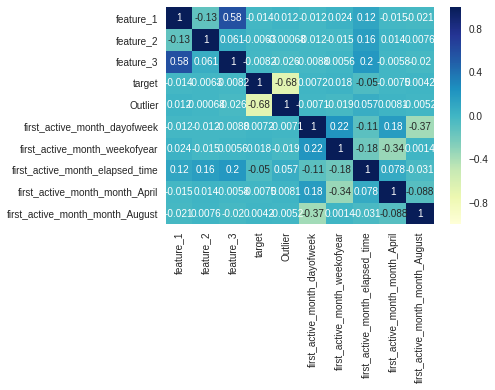

In [0]:
sns.heatmap(data_train_partcopy.iloc[:, :10].corr(), annot = True, cmap = "YlGnBu");

##### internal: distribution

In [0]:
for indent, each_feat in enumerate(list(data_train_partcopy.columns)):
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_feat)
    temp = data_train_partcopy.iloc[:, indent].value_counts()
    plt.plot(temp.values, list(temp.index), "o");
    gc.collect()
    sys._clear_type_cache()

Conclusions at 2019/2/2:

- distribution shows that the row with vacancy proportion larger than 15% should be dropped: accepted
- distribution shows that the columns with inidentical distribution should be dropped: accepted

In [0]:
temp = data_train.isnull().sum()/data_train.shape[0]*100
choices_1 = list(temp[temp > 15].index)

data_train.drop(choices_1, axis=1, inplace=True)
# data_train_partcopy.drop(choices_1, axis=1, inplace=True)

In [0]:
choices_2 = ['his_trans_category_3_A_mean', 'his_trans_purchase_amount_mean', 'his_trans_purchase_amount_max', 'his_trans_purchase_amount_std', 'his_trans_purchase_year_min', 'active_months_lag12_mean_x', 'active_months_lag12_max_x', 'active_months_lag12_min_x', 'active_months_lag3_mean_x', 'active_months_lag3_min_x', 'active_months_lag3_max_x', 'active_months_lag6_mean_x', 'active_months_lag6_max_x', 'active_months_lag6_min_x', 'city_id_nunique_x', 'state_id_nunique_x', 'active_months_lag12_mean_y', 'active_months_lag12_max_y', 'active_months_lag12_min_y', 'active_months_lag3_min_y', 'active_months_lag3_max_y', 'active_months_lag3_mean_y', 'active_months_lag6_mean_y', 'active_months_lag6_max_y', 'active_months_lag6_min_y', 'avg_sales_lag12_mean_y', 'avg_sales_lag12_max_y', 'avg_sales_lag12_min_y', 'avg_sales_lag3_mean_y', 'avg_sales_lag3_min_y', 'avg_sales_lag6_mean_y', 'avg_sales_lag6_max_y', 'avg_sales_lag6_min_y', 'city_id_nunique_y', 'state_id_nunique_y', 'purchase_amount_mean_mean', 'purchase_amount_mean_std', 'purchase_amount_max_mean', 'purchase_amount_max_std', 'purchase_amount_std_mean', 'purchase_amount_std_std', 'installments_std_mean', 'installments_std_std', 'his_trans_purchase_amount_mean', 'his_trans_purchase_month_April_min', 'his_trans_purchase_month_August_min', 'his_trans_purchase_month_December_min', 'his_trans_purchase_month_February_min', 'his_trans_purchase_month_January_min', 'his_trans_purchase_month_July_min', 'his_trans_purchase_month_June_min', 'his_trans_purchase_month_March_min', 'his_trans_purchase_month_May_min', 'his_trans_purchase_month_November_min', 'his_trans_purchase_month_October_min', 'his_trans_purchase_month_September_min', 'new_trans_purchase_month_April_min', 'new_trans_purchase_month_April_mean', 'new_trans_purchase_month_August_min', 'new_trans_purchase_month_August_mean', 'new_trans_purchase_month_December_min', 'new_trans_purchase_month_December_mean', 'new_trans_purchase_month_February_min', 'new_trans_purchase_month_February_mean', 'new_trans_purchase_month_January_min', 'new_trans_purchase_month_January_mean', 'new_trans_purchase_month_July_min', 'new_trans_purchase_month_July_mean', 'new_trans_purchase_month_March_min', 'new_trans_purchase_month_March_mean', 'new_trans_purchase_month_November_min', 'new_trans_purchase_month_November_mean', 'new_trans_purchase_month_October_min', 'new_trans_purchase_month_October_mean', 'new_trans_purchase_month_September_min', 'new_trans_purchase_month_September_mean', 'new_trans_purchase_month_August_min', 'new_trans_purchase_month_August_mean', 'new_trans_purchase_month_June_mean', 'new_trans_purchase_month_June_min']

data_train.drop(choices_2, axis=1, inplace=True)
# data_train_partcopy.drop(choices_2, axis=1, inplace=True)

##### internal:  vacancy

In [0]:
data_train_partcopy_vacancy_asses = data_train_partcopy.isnull().sum()
data_train_partcopy_vacancy_asses

[Output] Display column vacancy percentage distribution of training data: 


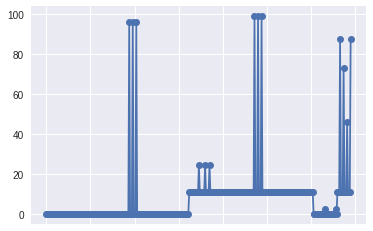

In [0]:
print("[Output] Display column vacancy percentage distribution of training data: ")
(100*data_train_partcopy_vacancy_asses/data_train_partcopy.shape[0]).plot(marker="o");
# TODO 2019/1/24: add labels to every point

In [0]:
data_train_partcopy_vacancy_asses = np.array([data_train_partcopy.iloc[indent, :].isnull().sum() for indent in range(len(data_train_partcopy))])
row_vacancy_ave = data_train_partcopy_vacancy_asses.sum() / (len(data_train_partcopy_vacancy_asses))
data_train_partcopy_low = data_train_partcopy[:][data_train_partcopy_vacancy_asses <= row_vacancy_ave]  # lower than average number
data_train_partcopy_high = data_train_partcopy[:][data_train_partcopy_vacancy_asses > row_vacancy_ave]  # higher than average number

In [0]:
row_vacancy_ave

11.82065591467068

[Output] Display row vacancy distribution of training data: 


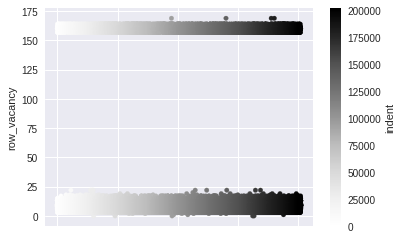

In [0]:
data_train_partcopy_vacancy_asses_df = pd.DataFrame(data=data_train_partcopy_vacancy_asses, columns=["row_vacancy"])
# print(data_train_partcopy_vacancy_asses_df)
data_train_partcopy_vacancy_asses_df["indent"] = list(data_train_partcopy_vacancy_asses_df.index)
print("[Output] Display row vacancy distribution of training data: ")
data_train_partcopy_vacancy_asses_df.plot.scatter(x="indent", y="row_vacancy", c="indent");

In [0]:
data_train_partcopy_high.head()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


ValueError: ignored

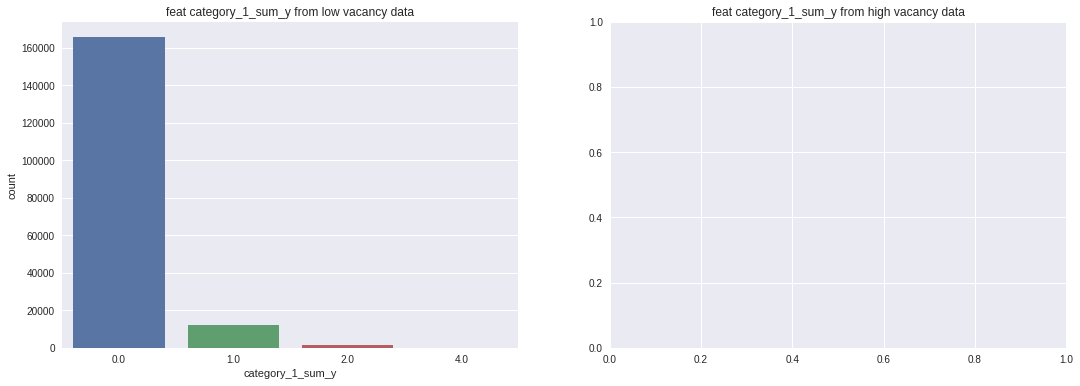

In [0]:
# TODO 2019/2/2: one error left unsolved


num = 100
mean_dict, std_dict = {"low_vacancy_data":[], "high_vacancy_data":[]}, {"low_vacancy_data":[], "high_vacancy_data":[]}
sns.set(style="darkgrid")
feat_selected = random.sample(list(data_train_partcopy.columns), num)

for indent in range(num):
    compare_dis(data_train_partcopy_low.dropna().loc[:, list(data_train_partcopy.columns)], data_train_partcopy_high.dropna().loc[:, list(data_train_partcopy.columns)], feat_selected[indent], indent)
    gc.collect()
    sys._clear_type_cache()
    
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
mean_df.plot(marker="o");
std_df.plot(marker="o");

Conclusions at 2019/1/24:

- statistical analysis, distribution shows that "category_2" should be dropped: rejected(by the second analysis)
- vacancy relationships along row direction show that "city_id", "purchase_amount", "authorized_flag", "month_lag" should be dropped: accepted

In [0]:
choices = ["city_id", "purchase_amount", "authorized_flag", "month_lag"]

data_train_mod2 = data_train_mod2.drop(choices, axis=1)
[data_train_mod2_columns_num.remove(each_choice) for each_choice in choices];

Conclusions at 2019/2/3:

- Not finished yet

In [0]:
choices_1 = []

data_train.drop(choices_1, axis=1, inplace=True)
data_train_partcopy.drop(choices_1, axis=1, inplace=True)

save or read data

In [0]:
# data_train.to_csv(DATA_ROOT_PATH+"data_processed/train/train_20190203.csv", index=False)
data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/train_20190203.csv")

#### numberical part of testing data

Conclusions at 2019/1/24:

- considering assumption iid(independent and identically distributed), keep selections the same as what is applied to training data

In [0]:
choices = ["city_id", "purchase_amount", "authorized_flag", "month_lag"]
data_test_mod2 = data_test_mod2.drop(["city_id", "purchase_amount", "authorized_flag", "month_lag"], axis=1)
[data_test_mod2_columns_num.remove(each_choice) for each_choice in choices];

In [0]:
temp = data_test.isnull().sum()/data_test.shape[0]*100
choices_1 = list(temp[temp > 15].index)

data_test.drop(choices_1, axis=1, inplace=True)
# data_test_partcopy.drop(choices_1, axis=1, inplace=True)

In [0]:
choices_2 = ['his_trans_category_3_A_mean', 'his_trans_purchase_amount_mean', 'his_trans_purchase_amount_max', 'his_trans_purchase_amount_std', 'his_trans_purchase_year_min', 'active_months_lag12_mean_x', 'active_months_lag12_max_x', 'active_months_lag12_min_x', 'active_months_lag3_mean_x', 'active_months_lag3_min_x', 'active_months_lag3_max_x', 'active_months_lag6_mean_x', 'active_months_lag6_max_x', 'active_months_lag6_min_x', 'city_id_nunique_x', 'state_id_nunique_x', 'active_months_lag12_mean_y', 'active_months_lag12_max_y', 'active_months_lag12_min_y', 'active_months_lag3_min_y', 'active_months_lag3_max_y', 'active_months_lag3_mean_y', 'active_months_lag6_mean_y', 'active_months_lag6_max_y', 'active_months_lag6_min_y', 'avg_sales_lag12_mean_y', 'avg_sales_lag12_max_y', 'avg_sales_lag12_min_y', 'avg_sales_lag3_mean_y', 'avg_sales_lag3_min_y', 'avg_sales_lag6_mean_y', 'avg_sales_lag6_max_y', 'avg_sales_lag6_min_y', 'city_id_nunique_y', 'state_id_nunique_y', 'purchase_amount_mean_mean', 'purchase_amount_mean_std', 'purchase_amount_max_mean', 'purchase_amount_max_std', 'purchase_amount_std_mean', 'purchase_amount_std_std', 'installments_std_mean', 'installments_std_std', 'his_trans_purchase_amount_mean', 'his_trans_purchase_month_April_min', 'his_trans_purchase_month_August_min', 'his_trans_purchase_month_December_min', 'his_trans_purchase_month_February_min', 'his_trans_purchase_month_January_min', 'his_trans_purchase_month_July_min', 'his_trans_purchase_month_June_min', 'his_trans_purchase_month_March_min', 'his_trans_purchase_month_May_min', 'his_trans_purchase_month_November_min', 'his_trans_purchase_month_October_min', 'his_trans_purchase_month_September_min', 'new_trans_purchase_month_April_min', 'new_trans_purchase_month_April_mean', 'new_trans_purchase_month_August_min', 'new_trans_purchase_month_August_mean', 'new_trans_purchase_month_December_min', 'new_trans_purchase_month_December_mean', 'new_trans_purchase_month_February_min', 'new_trans_purchase_month_February_mean', 'new_trans_purchase_month_January_min', 'new_trans_purchase_month_January_mean', 'new_trans_purchase_month_July_min', 'new_trans_purchase_month_July_mean', 'new_trans_purchase_month_March_min', 'new_trans_purchase_month_March_mean', 'new_trans_purchase_month_November_min', 'new_trans_purchase_month_November_mean', 'new_trans_purchase_month_October_min', 'new_trans_purchase_month_October_mean', 'new_trans_purchase_month_September_min', 'new_trans_purchase_month_September_mean', 'new_trans_purchase_month_August_min', 'new_trans_purchase_month_August_mean', 'new_trans_purchase_month_June_mean', 'new_trans_purchase_month_June_min']

data_test.drop(choices_2, axis=1, inplace=True)
# data_test_partcopy.drop(choices_2, axis=1, inplace=True)

save or read data

In [0]:
# data_test.to_csv(DATA_ROOT_PATH+"data_processed/test/test_20190203.csv", index=False)
data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/test_20190203.csv")

##### external: analysis between training data and testing data

In [0]:
for indent, each_column in enumerate(list(data_test.columns)): 
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_column)
    sns.distplot(data_train[each_column].dropna(), color="g", ax=ax1)
    sns.distplot(data_test[each_column].dropna(), color="b", ax=ax1)

##### conclusions

Conclusions at 2019/1/16:

- It seems like data needs expansion instead of squeezing because of the insufficient features and insufficient description of data
- Compare column vacancy, vacancy distributes nearly equally except for the original columns of training data(no vacancy)
- Compare row vacancy, different columns may not cause considerate distribution differences, which indicates no change will be applied

Conclusions at 2019/1/24:

- it seems difficult to distinguish training data and testing data from remaining numberical features

### fill NaNs

In [0]:
data_train.info(verbose=True)

In [0]:
data_test.info(verbose=True)

#### fill non-numberical data

In [0]:
# data_train_nonnum.fillna(method="ffill", inplace=True)
# data_test_nonnum.fillna(method="ffill", inplace=True)

In [0]:
# data_train_nonnum_converted = pd.get_dummies(data_train_nonnum.loc[:, data_train_columns_nonnum])
# data_test_nonnum_converted = pd.get_dummies(data_test_nonnum.loc[:, data_test_columns_nonnum])

#### fill numberical data

In [0]:
from sklearn.preprocessing import Imputer

data_train.drop(["card_id"], axis=1, inplace=True)
data_test.drop(["card_id"], axis=1, inplace=True)
filler_vacancy = Imputer()
data_train_nonull = pd.DataFrame(data=filler_vacancy.fit_transform(data_train), columns=data_train.columns)
data_test_nonull = pd.DataFrame(data=filler_vacancy.fit_transform(data_test), columns=data_test.columns)

# data_train_nonull.reset_index(inplace=True)
# data_test_nonull.reset_index(inplace=True)

In [0]:
for indent, each_column in enumerate(data_test_nonull.columns):
    # feature = np.random.choice(list(data_test_columns_num_copy), select_num)
    # for indent in range(select_num):   
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_column)
    sns.distplot(data_train_nonull[each_column].dropna(), color="g", ax=ax1)
    sns.distplot(data_test_nonull[each_column].dropna(), color="b", ax=ax1)

In [0]:
data_train_nonull.shape

(201917, 333)

save and read data

In [0]:
# data_train_full = pd.concat([data_train_nonnum_converted, data_train_num_nonull], axis=1)
# data_test_full = pd.concat([data_test_nonnum_converted, data_test_num_nonull], axis=1)

print("[Output] Save full training data after expansion, comparison and filling nan: ")
data_train_nonull.to_csv(DATA_ROOT_PATH+"data_processed/train/train_nonull_20190203.csv", index=False)
print("[Output] Save full testing data  after expansion, comparison and filling nan: ")
data_test_nonull.to_csv(DATA_ROOT_PATH+"data_processed/test/test_nonull_20190203.csv", index=False)

# data_train_nonull = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/train_nonull_20190203.csv")
# data_test_nonull = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/test_nonull_20190203.csv")

[Output] Save full training data after expansion, comparison and filling nan: 
[Output] Save full testing data  after expansion, comparison and filling nan: 


## last process

### apply scaler

In [0]:
# Note 2019/2/3: abandon below method for the same change applied to VARIABLE temp 
# temp = data_train_nonull
# data_train_nonull.drop(["Outlier"], axis=1, inplace=True)
# temp["Outlier"] 

data_train_nonull_part = data_train_nonull.drop(["Outlier"], axis=1)

In [0]:
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import Normalizer


scaler_std = StandardScaler()
data_train_full_scaled = pd.DataFrame(data=scaler_std.fit_transform(data_train_nonull_part), columns=data_train_nonull_part.columns)
data_test_full_scaled = pd.DataFrame(data=scaler_std.fit_transform(data_test_nonull), columns=data_test_nonull.columns)

In [0]:
data_train_full_scaled.shape

(201917, 332)

In [0]:
data_train_full_scaled["Outlier"] = data_train_nonull["Outlier"]  # Note 2019/2/3: not use "." because no column shall be added

In [0]:
data_train_full_scaled.shape

(201917, 333)

### select feat

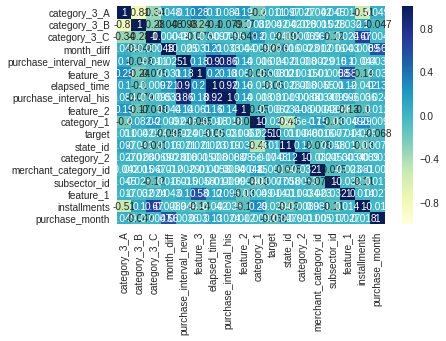

In [0]:
data_train_full_scaled_copy = copy.copy(data_train_full_scaled)
sns.heatmap(data_train_full_scaled_copy.corr(), annot = True, cmap = "YlGnBu");

In [0]:
from sklearn import feature_selection


# @functools.lru_cache(maxsize=128) 
def select_feature(features_num, data, labels):
    fselector = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=features_num)
    fselector.fit(data, labels)
    mask = fselector.get_support()
    indent = 0
    feature_names_selected = []
    for indent in range(len(mask)):
        if mask[indent]:
            feature_names_selected.append(list(data.columns)[indent])
        gc.collect()
        sys._clear_type_cache()
    return  feature_names_selected

In [0]:
labels_train = data_train["target"].astype("float")

In [0]:
labels_train = [math.floor(item) for item in data_train_full["target"].astype("float")]
data_train_part_scaled = data_train_full_scaled.drop(["target"], axis=1)
feature_train_selected = select_feature(12, data_train_part_scaled, labels_train)
data_train_full_scaled_selected = data_train_full_scaled.loc[:, feature_train_selected]
data_test_full_scaled_selected = data_test_full_scaled.loc[:, feature_train_selected]

### save and read data

In [0]:
print("[Output] Save sacled training data after expansion, comparison and filling nan: ")
data_train_full_scaled.to_csv(DATA_ROOT_PATH+"data_processed/train/train_full_scaled_20190203.csv", index=False)
print("[Output] Save scaled testing data after expansion, comparison and filling nan: ")
data_test_full_scaled.to_csv(DATA_ROOT_PATH+"data_processed/test/test_full_scaled_20190203.csv", index=False)

# print("[Output] Save selected training data after expansion, comparison, filling nan and scaling: ")
# data_train_full_scaled_selected.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv", index=False)
# print("[Output] Save selected testing data after expansion, comparison, filling nan and scaling: ")
# data_test_full_scaled_selected.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv", index=False)

[Output] Save sacled training data after expansion, comparison and filling nan: 
[Output] Save scaled testing data after expansion, comparison and filling nan: 


In [0]:
data_train_full_scaled = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/train_full_scaled_20190203.csv")
data_test_full_scaled = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/test_full_scaled_20190203.csv")

# data_train_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv")
# data_test_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv")

In [0]:
# data_train_full_scaled.head()
data_train_full_scaled.info(verbose=True)

In [0]:
# data_test_full_scaled.head()
data_test_full_scaled.info(verbose=True)

# Test Parts

In [0]:
gc.collect()
sys._clear_type_cache()

##  simple data transportation from new transaction and historical transaction data

In [0]:
# @functools.lru_cache(maxsize=128)  # TypeError: "DataFrame" objects are mutable, thus they cannot be hashed
def expand_data(data_ori, data_external, column_ref, flag_expand):
    
    # columns_added = [each_column if each_column not in data_ori.columns else "Exisisted" for each_column in data_external.columns]
    
    if len(data_ori) == len(set(data_ori.loc[:, column_ref])):
        pass
    else:
        pass # TODO 2019/1/9: how to deal this situation? 
    data_new = copy.copy(data_ori)
    data_external_mod1 = copy.copy(data_external) 
    data_external_mod1.drop_duplicates(subset="card_id", inplace=True)  # TODO 2019/1/14: how to deal with the duplicate transaction record? 
    columns_added = []
    for each_column in data_external.columns:
        if each_column not in data_ori.columns:
            columns_added.append(each_column)
            data_new[each_column] = np.array([np.nan] * len(data_ori))
    
    # content = [data_external[columns_added][data_external[column_ref]==index] for index in data_ori[column_ref]]  # TODO 2019/1/9: a more efficient way to expand whole data?
    
    id_inter = list(set(data_new[column_ref]).intersection(set(data_external_mod1[column_ref])))
    # return(id_inter)
    data_new.set_index(data_new[column_ref], inplace=True)
    data_external_mod1.set_index(data_external_mod1[column_ref], inplace=True)   
    data_new.loc[id_inter, columns_added] = data_external_mod1.loc[id_inter, columns_added]  # TODO 2019/1/11: ValueError: cannot reindex from a duplicate axis
    data_new_copy = copy.copy(data_new)
    if flag_expand == "new":
        data_new.loc[id_inter, "purchase_interval_new"] = (data_external_mod1.loc[id_inter, "purchase_date"].dt.date - data_new_copy.loc[id_inter,"first_active_month"].dt.date).dt.days
    elif flag_expand == "his":
        data_new.loc[id_inter, "purchase_interval_his"] = (data_external_mod1.loc[id_inter, "purchase_date"].dt.date - data_new_copy.loc[id_inter,"first_active_month"].dt.date).dt.days        
    gc.collect()
    sys._clear_type_cache()
    return data_new

In [0]:
data_train_mod1 = expand_data(data_train, data_new_merchant_transactions, "card_id", "new")
data_train_mod2 = expand_data(data_train_mod1, data_historical_transactions, "card_id", "his")
print("[Output] Save expanded training data by raw data file {}: ".format("data_new_merchant_transactions"))
data_train_mod1.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded.csv")
print("[Output] Save expanded training data by raw data file {} and {}: ".format("data_new_merchant_transactions", "data_historical_transactions"))
data_train_mod2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded2.csv")

[Output] Save expanded training data by raw data file data_new_merchant_transactions: 
[Output] Save expanded training data by raw data file data_new_merchant_transactions and data_historical_transactions: 


In [0]:
data_test_mod1 = expand_data(data_test, data_new_merchant_transactions, "card_id", "new")
data_test_mod2 = expand_data(data_test_mod1, data_historical_transactions, "card_id", "his")
print("[Output] Save expanded testing data by raw data file {}: ".format("data_new_merchant_transactions"))
data_test_mod1.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded.csv")
print("[Output] Save expanded testing data by raw data file {} and {}: ".format("data_new_merchant_transactions", "data_historical_transactions"))
data_test_mod2.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded2.csv")

[Output] Save expanded testing data by raw data file data_new_merchant_transactions: 
[Output] Save expanded testing data by raw data file data_new_merchant_transactions and data_historical_transactions: 


In [0]:
data_train_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded.csv")
data_train_mod2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded2.csv")
data_test_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded.csv")
data_test_mod2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded2.csv")

## for data

In [0]:
# calculate factorial


from functools import reduce
result = reduce(lambda x,y:x*y,range(1,num_stop+1))

### by pandas

In [0]:
df..plot.scatter/bar/...

In [0]:
df.isnull.sum().mean()  # provide a pandas series of the percentage of each row vacancy

In [0]:
df.columnA.value_counts()  # provide a pandas series of the counts for a specified column

In [0]:
df["Sample_mod"] = df["Sample"].apply(func_sample)

In [0]:
df.style.bar(subset=["Sample"], align="mid", color=["#d65f5f", "#5fba7d"])

In [0]:
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']
temp['purchase_month'] = pd.Categorical(temp['purchase_month'], categories = month_labels, 
                                          ordered = True)

In [0]:
df_obj = df.select_dtypes(include=['object']).copy()

In [0]:
fill_mode = lambda col: col.fillna(col.mode()[0])

new_df.apply(fill_mode, axis=0)

### by matplotlib

In [0]:
fig, axes = plt.subplots(2,sharex=True)
fig.subplots_adjust(hspace=.5)
axes[0].hist(self.data, density=True)
axes[0].set_title('Normed Histogram of Data')
axes[0].set_ylabel('Density')

axes[1].plot(x, y)
axes[1].set_title('Normal Distribution for \n Sample Mean and Sample Standard Deviation')
plt.show()


## for algorithm or package

In [0]:
import tushare as ts


data_stock = ts.get_hist_data("600519")
data_stock.isna().sum()
# data_stock.index
print(data_stock.columns, type(data_stock))

## Table Forms

Forms provide an easy way to parameterize code. From a code cell, select **Insert → Add form field**.  When you change the value in a form, the corresponding value in the code will change. 

In [0]:
#@title String fields

text = 'value' #@param {type:"string"}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]
text_and_dropdown = 'value' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}

print(text)
print(dropdown)
print(text_and_dropdown)

In [0]:
#@title Raw fields

raw_input = None #@param {type:"raw"}
raw_dropdown = raw_input #@param [1, "raw_input", "False", "'string'"] {type:"raw"}

print(raw_input)
print(raw_dropdown)

In [0]:
#@title Date fields
date_input = '2018-03-22' #@param {type:"date"}

print(date_input)

In [0]:
#@title Number fields
number_input = 10.0 #@param {type:"number"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}

integer_input = 10 #@param {type:"integer"}
integer_slider = 1 #@param {type:"slider", min:0, max:100, step:1}

print(number_input)
print(number_slider)

print(integer_input)
print(integer_slider)

In [0]:
#@title Boolean fields
boolean_checkbox = True #@param {type:"boolean"}
boolean_dropdown = True #@param ["False", "True"] {type:"raw"}

print(boolean_checkbox)
print(boolean_dropdown)

### Hiding code

You can change the view of the form by selecting **Edit → Show/hide code** or using the toolbar above the selected code cell. You can see both code and the form, just the form, or just the code.

In [0]:
#@title ## Markdown
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter a file path:
file_path = "" #@param {type:"string"}
#@markdown ---

